In [21]:
#Importing packages
#Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
#Sklearn
from sklearn import model_selection, linear_model
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,RepeatedStratifiedKFold,cross_validate
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,auc,roc_auc_score,roc_curve,classification_report

In [22]:
#Others
import random
import pandas as pd
from pandas import DataFrame
from pandas import Series
import numpy as np
import math
import os
import warnings
import optuna
import joblib

In [23]:
#Setting the Work Path
warnings.filterwarnings ('ignore')
#Work Path
os.chdir("C:/Users/A/Desktop/Bioactive/HIV")

In [24]:
def Model_results(Model_clf,X_test,y,Cv_model):
    Model_scores= cross_validate(estimator=Model_clf, X=X_test, y=y, cv=Cv_model,scoring=( 'accuracy','f1','precision','recall','roc_auc'), return_train_score=True)
    Model_score= cross_validate(estimator=Model_clf, X=X_test, y=y, cv=Cv_model,scoring=( 'accuracy','f1','precision','recall','roc_auc'), return_train_score=False)
#Accuracy
    Model_Accuracy_test_mean=Model_scores['test_accuracy'].mean()
    Model_Accuracy_test_se=(Model_scores['test_accuracy'].std()/math.sqrt(len(Model_scores['test_accuracy']))) 
    Model_Accuracy_train_mean=Model_scores['train_accuracy'].mean()
    Model_Accuracy_train_se=(Model_scores['train_accuracy'].std()/math.sqrt(len(Model_scores['train_accuracy']))) 
#f1
    Model_f1_mean=Model_score['test_f1'].mean()
    Model_f1_se=(Model_score['test_f1'].std()/math.sqrt(len(Model_score['test_f1']))) 
#precision
    Model_precision_mean=Model_score['test_precision'].mean()
    Model_precision_se=(Model_score['test_precision'].std()/math.sqrt(len(Model_score['test_precision']))) 
#recall
    Model_recall_mean=Model_score['test_recall'].mean()
    Model_recall_se=(Model_score['test_recall'].std()/math.sqrt(len(Model_score['test_recall']))) 
#roc_auc
    Model_roc_auc_mean=Model_score['test_roc_auc'].mean()
    Model_roc_auc_se=(Model_score['test_roc_auc'].std()/math.sqrt(len(Model_score['test_roc_auc']))) 
    Model = {'Mean':[Model_Accuracy_test_mean,Model_Accuracy_train_mean,Model_f1_mean,Model_precision_mean,Model_recall_mean,Model_roc_auc_mean],
        'Se':[Model_Accuracy_test_se,Model_Accuracy_train_se,Model_f1_se,Model_precision_se,Model_recall_se,Model_roc_auc_se]}
    Model = pd.DataFrame(Model, index=['Accuracy_test','Accuracy_train','F1 Score','Precision','Recall','Roc_auc']) # 这里设定了 index 个数要和列表长度一致
    return Model

In [25]:
Cv_optuna= RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)
Cv_model= RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)
Cv_RFECV= RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

In [26]:
#Reading the data
ML_data= pd.read_csv("./ML_data.csv",header=0,index_col=0)
X_NAomit_data= pd.read_csv("./X_NAomit_data.csv",header=0,index_col=0)
Raw_data = pd.read_csv('./Original_data.csv',index_col=0)
#original data(descriptors= 4175）
print(X_NAomit_data.shape)
X_NAomit_data.head()

(1919, 3764)


,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,s1_numAroBonds,s2_numAroBonds,s3_numAroBonds,s4_numAroBonds,s34_size,s34_relSize,s34_phSize,s34_phRelSize,chiralMoment,chiralPhMoment
cid,,,,,,,,,,,,,,,,,,,,,
395575,636.75,7.404070,53.3988,87.2723,55.2275,96.6074,0.620916,1.014794,0.642180,1.123342,...,0.0,1.333333,0.0,5.0,39.333333,0.855072,9.75,0.211957,50.709583,12.622331
15604702,360.26,10.595882,22.5817,34.8944,23.9490,38.3759,0.664168,1.026306,0.704382,1.128703,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
16045493,444.27,10.577857,31.2089,43.7417,31.3978,47.2140,0.743069,1.041469,0.747567,1.124143,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
146894788,637.90,6.786170,57.0290,93.3738,60.8359,106.0483,0.606691,0.993338,0.647190,1.128173,...,0.0,0.000000,11.0,11.0,41.000000,0.872340,8.50,0.180851,39.957758,9.293476
69480289,425.50,7.736364,35.1015,55.8469,36.1480,62.2394,0.638209,1.015398,0.657236,1.131625,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000


In [27]:
Raw_data

,Activite,IsomericSMILES,Canonical_smiles
cid,,,
395575,1,CC1=CC(=O)OC2=C1C=CC3=C2[C@H]([C@H](C(O3)(C)C)...,Cc1cc(=O)oc2c3c(ccc12)OC(C)(C)[C@H](OC(=O)C12C...
15604702,1,CCCNS(=O)(=O)C1=C(NC2=C1C=C(C=C2)Br)C(=O)N,CCCNS(=O)(=O)c1c(C(N)=O)[nH]c2ccc(Br)cc12
16045493,1,C1=CC(=NC2=NNC(=C21)COC3=CC(=C(C(=C3)F)Cl)OC4=...,N#Cc1cc(Cl)cc(Oc2cc(OCc3[nH]nc4nc(N)ccc34)cc(F...
146894788,1,CCC(=O)CCCCC[C@@H](C1=NC=C(N1)C2=CC3=CC=CC=C3N...,CCC(=O)CCCCC[C@H](NC(=O)[C@H]1CC12CCN(Cc1ccc(O...
69480289,1,CN1C2=C(C(=C(C1=O)C(=O)NC3(CCCC3)CO)O)N=CC(=C2...,Cn1c(=O)c(C(=O)NC2(CO)CCCC2)c(O)c2ncc(Cc3ccc(F...
...,...,...,...
44582935,0,CC1=C(C(=CC=C1)C)C2N(C(=O)CS2)C3=NC=CC(=C3)Br,Cc1cccc(C)c1C1SCC(=O)N1c1cc(Br)ccn1
44583099,0,CCC1CCC1N2C(SCC2=O)C3=C(C=CC=C3Cl)Cl,CCC1CCC1N1C(=O)CSC1c1c(Cl)cccc1Cl
44583063,0,CC1=CC(=C(N1)N2C(SCC2=S)C3=C(C=CC=C3F)F)C,Cc1cc(C)c(N2C(=S)CSC2c2c(F)cccc2F)[nH]1


In [28]:
#Data after feature selection (descriptors= 64）
print(ML_data.shape)
ML_data.head()

(1919, 277)


,IC2,F05[N-O],Vindex,SHED_AL,SM6_B(v),CATS2D_05_AA,F08[C-N],F03[N-O],P_VSA_LogP_4,B10[C-N],...,B08[N-S],CATS2D_01_DA,B05[O-S],GATS5m,GATS5e,nCconj,MATS7i,CATS2D_02_AP,GATS8v,C-033
cid,,,,,,,,,,,,,,,,,,,,,
395575,0.632912,0.000000,0.001753,0.587693,0.488822,0.173913,0.000000,0.00000,0.085719,0.0,...,0.0,0.00,0.0,0.481970,0.666269,0.230769,0.386765,0.000000,0.453823,0.0
15604702,0.687508,0.049180,0.004050,0.280869,0.352709,0.043478,0.005208,0.02439,0.039319,0.0,...,0.0,0.00,0.0,0.357018,0.601275,0.076923,0.309712,0.111111,0.545744,0.0
16045493,0.744037,0.032787,0.001925,0.644351,0.428686,0.043478,0.036458,0.02439,0.026535,1.0,...,0.0,0.25,0.0,0.429851,0.431305,0.000000,0.342645,0.111111,0.371304,0.0
146894788,0.837700,0.049180,0.001296,0.943130,0.485042,0.065217,0.083333,0.00000,0.057152,1.0,...,0.0,0.00,0.0,0.479589,0.481747,0.000000,0.345767,0.000000,0.399689,0.0
69480289,0.747104,0.032787,0.002074,0.584483,0.394648,0.065217,0.020833,0.04878,0.069420,1.0,...,0.0,0.00,0.0,0.517585,0.536060,0.307692,0.366048,0.000000,0.478147,0.0


# DT

In [9]:
#Data pre-processing of models
X_test_NAomit=np.array(X_NAomit_data)
X_test_ML=np.array(ML_data)
y=Raw_data['Activite'].values
clf=DecisionTreeClassifier(random_state=0)

In [10]:
#Model1 （4175 descriptors）
Model1_clf=clf
#Model1
Model1=Model_results(Model1_clf,X_test_NAomit,y,Cv_model)
Model1

,Mean,Se
Accuracy_test,0.814486,0.002366
Accuracy_train,0.992936,0.000084
F1 Score,0.818623,0.002409
Precision,0.821193,0.002959
Recall,0.817465,0.003761
Roc_auc,0.816574,0.002429


In [11]:
#Model2 （40 descriptors）
Model2_clf=clf
Model2_clf.fit(X_test_ML, y)
#Model2
Model2=Model_results(Model2_clf,X_test_ML,y,Cv_model)
Model2

,Mean,Se
Accuracy_test,0.812763,0.002668
Accuracy_train,0.992936,0.000084
F1 Score,0.817996,0.002622
Precision,0.816157,0.003236
Recall,0.821103,0.003641
Roc_auc,0.814328,0.002629


In [12]:
#Tuning hyperparameters
#Step 1. Define an objective function to be maximized.
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth',3,5,1),
        'max_features' : trial.suggest_int("max_features",10,20,1),
        'min_samples_split':trial.suggest_int('min_samples_split',2,25,1)
    }
    model = DecisionTreeClassifier(**param,random_state=1)

 
# Step 2: Scoring method:
    score = model_selection.cross_val_score(model, X_test_ML, y, n_jobs=8, scoring="accuracy",cv=Cv_optuna)
    accuracy = score.mean()
    return accuracy
 
# Step 3: Running it
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective, n_trials=100, show_progress_bar=False)


[I 2023-11-06 19:50:19,840] A new study created in memory with name: no-name-19b160b6-dfb8-477e-9a5a-1fa25ac672cd
[I 2023-11-06 19:50:24,244] Trial 0 finished with value: 0.7324078315881324 and parameters: {'max_depth': 4, 'max_features': 17, 'min_samples_split': 16}. Best is trial 0 with value: 0.7324078315881324.
[I 2023-11-06 19:50:24,734] Trial 1 finished with value: 0.72673347513089 and parameters: {'max_depth': 4, 'max_features': 14, 'min_samples_split': 17}. Best is trial 0 with value: 0.7324078315881324.
[I 2023-11-06 19:50:25,503] Trial 2 finished with value: 0.7320457024432809 and parameters: {'max_depth': 4, 'max_features': 19, 'min_samples_split': 25}. Best is trial 0 with value: 0.7324078315881324.
[I 2023-11-06 19:50:26,164] Trial 3 finished with value: 0.7285111256544501 and parameters: {'max_depth': 4, 'max_features': 18, 'min_samples_split': 14}. Best is trial 0 with value: 0.7324078315881324.
[I 2023-11-06 19:50:27,009] Trial 4 finished with value: 0.7349154668411866 

In [13]:
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")
# Setting the best model
clf =DecisionTreeClassifier(max_depth = study.best_params['max_depth']
              ,max_features = study.best_params['max_features']
              #,n_estimators = study.best_params['n_estimators']
              #,learning_rate = study.best_params['learning_rate']
              ,min_samples_split= study.best_params['min_samples_split']
              ,random_state=1)

The best parameters are : 
{'max_depth': 5, 'max_features': 13, 'min_samples_split': 8}


In [14]:
#Model3
Model3=Model_results(clf,X_test_ML,y,Cv_model)
Model3

,Mean,Se
Accuracy_test,0.765445,0.003164
Accuracy_train,0.808807,0.001438
F1 Score,0.779519,0.003037
Precision,0.754690,0.004185
Recall,0.810460,0.005794
Roc_auc,0.825658,0.003425


In [15]:
#Recursive feature elimination
min_features_to_select =5
rfecv = RFECV(estimator=clf,step=1,cv=Cv_RFECV,scoring="accuracy",min_features_to_select=min_features_to_select,n_jobs=8)
rfecv.fit(X_test_ML,y)
columns=Series(ML_data.columns.tolist())[rfecv.support_.tolist()].tolist()

In [16]:
data_dt=ML_data[columns]
data_dt.to_csv("./data_dt.csv",sep=',')
X_DT=np.array(data_dt)

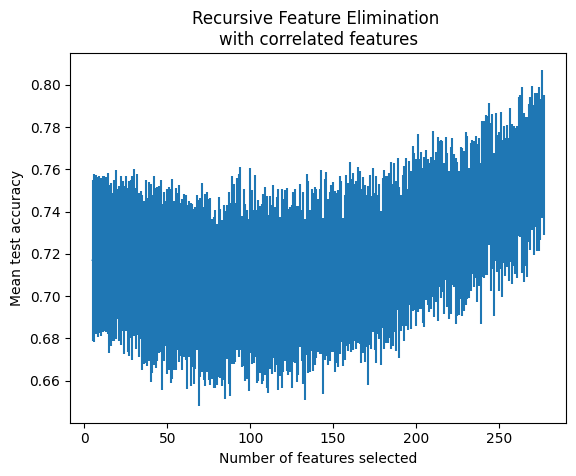

In [18]:
import matplotlib.pyplot as plt
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [19]:
#Model4 （len(columns) descriptors）
Model4_clf=DecisionTreeClassifier(max_depth = study.best_params['max_depth']
              ,max_features = study.best_params['max_features']
              #,n_estimators = study.best_params['n_estimators']
              #,learning_rate = study.best_params['learning_rate']
              ,min_samples_split= study.best_params['min_samples_split']
              ,random_state=1)
Model4_clf.fit(X_DT, y)
#Model4
Model4=Model_results(Model4_clf,X_DT,y,Cv_model)
Model4


,Mean,Se
Accuracy_test,0.769727,0.003313
Accuracy_train,0.817480,0.001079
F1 Score,0.770767,0.003573
Precision,0.787436,0.003929
Recall,0.757380,0.005438
Roc_auc,0.807435,0.003428


In [20]:
Model4_clf=Model4_clf.fit(X_DT, y)
#Saving the final model
joblib.dump(Model4_clf, './DT.pkl')
DT= joblib.load(filename='./DT.pkl')

In [21]:
#Saving the data of model performance
Model_data=pd.concat([Model1,Model2,Model3,Model4],axis=1)
Model_data.to_csv("./DT_model_data.csv",sep=',')
Model_data.columns = [['DecisionTree']*8,['Model 1','Model 1', 'Model 2','Model 2', 'Model 3', 'Model 3', 'Model 4', 'Model 4'], ['Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se']]  
Model_data.columns.names=['Method','Model','Values']
Model_data.to_csv('./DT_model_data.csv',encoding='utf-8')
#Read data：pd.read_csv('./Results/DT_model_data.csv',encoding='utf-8',header=[0,1,2])
Model_data

Method         DecisionTree                                                    \
Model               Model 1             Model 2             Model 3             
Values                 Mean        Se      Mean        Se      Mean        Se   
Accuracy_test      0.814486  0.002366  0.812763  0.002668  0.765445  0.003164   
Accuracy_train     0.992936  0.000084  0.992936  0.000084  0.808807  0.001438   
F1 Score           0.818623  0.002409  0.817996  0.002622  0.779519  0.003037   
Precision          0.821193  0.002959  0.816157  0.003236  0.754690  0.004185   
Recall             0.817465  0.003761  0.821103  0.003641  0.810460  0.005794   
Roc_auc            0.816574  0.002429  0.814328  0.002629  0.825658  0.003425   

Method                              
Model            Model 4            
Values              Mean        Se  
Accuracy_test   0.769727  0.003313  
Accuracy_train  0.817480  0.001079  
F1 Score        0.770767  0.003573  
Precision       0.787436  0.003929  
Recall          0.757380  0.005438  
Roc_auc         0.807435  0.003428

# LR

In [22]:
#Data pre-processing of models
X_test_NAomit=np.array(X_NAomit_data)
X_test_ML=np.array(ML_data)
y=Raw_data['Activite'].values
clf=LogisticRegression(solver='liblinear',random_state=0)

In [23]:
#Model1 （4175 descriptors）
Model1_clf=clf
#Model1
Model1=Model_results(Model1_clf,X_test_NAomit,y,Cv_model)
Model1

,Mean,Se
Accuracy_test,0.729074,0.003069
Accuracy_train,0.740275,0.001716
F1 Score,0.728109,0.003241
Precision,0.750605,0.003672
Recall,0.708691,0.004521
Roc_auc,0.783609,0.003179


In [24]:
#Model2 （40 descriptors）
Model2_clf=clf
Model2_clf.fit(X_test_ML, y)
#Model2
Model2=Model_results(Model2_clf,X_test_ML,y,Cv_model)
Model2

,Mean,Se
Accuracy_test,0.835016,0.002292
Accuracy_train,0.866684,0.000319
F1 Score,0.839378,0.002296
Precision,0.838525,0.002950
Recall,0.841572,0.003602
Roc_auc,0.901966,0.001950


In [25]:
#Tuning hyperparameters
#Step 1. Define an objective function to be maximized.
def objective(trial):
    logreg_c = trial.suggest_float("logreg_c", 1e-3,  1e3, log=True)
    l1_ratio = trial.suggest_float("l1_ratio",0.1,1,log=False) 
    #penalty = trial.suggest_categorical("penalty",['l1','l2'])
    max_iter = trial.suggest_int("max_iter", 100,2000)
    model =LogisticRegression(C=logreg_c,
                              max_iter=max_iter,
                              l1_ratio=l1_ratio,
                              solver='liblinear',random_state=1)
    
# Step 2: Scoring method:
    score = model_selection.cross_val_score(model, X_test_ML, y, n_jobs=8, scoring="accuracy",cv=Cv_optuna)
    accuracy = score.mean()
    return accuracy

# Step 3: Running it
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=1))
study.optimize(objective, n_trials=100, show_progress_bar=False)


[I 2023-11-06 23:26:53,273] A new study created in memory with name: no-name-f6a61362-0232-4879-8835-1f7f175498de
[I 2023-11-06 23:27:46,346] Trial 0 finished with value: 0.8241268542757417 and parameters: {'logreg_c': 0.3177840006884068, 'l1_ratio': 0.7482920440979423, 'max_iter': 100}. Best is trial 0 with value: 0.8241268542757417.
[I 2023-11-06 23:27:49,896] Trial 1 finished with value: 0.8056282722513087 and parameters: {'logreg_c': 0.0651621545821569, 'l1_ratio': 0.23208030173540176, 'max_iter': 275}. Best is trial 0 with value: 0.8241268542757417.
[I 2023-11-06 23:27:53,171] Trial 2 finished with value: 0.7573729275741712 and parameters: {'logreg_c': 0.013108749615263334, 'l1_ratio': 0.411004654338743, 'max_iter': 854}. Best is trial 0 with value: 0.8241268542757417.
[I 2023-11-06 23:28:00,284] Trial 3 finished with value: 0.8387682700698079 and parameters: {'logreg_c': 1.7096232052870346, 'l1_ratio': 0.4772750629629653, 'max_iter': 1402}. Best is trial 3 with value: 0.838768270

In [26]:
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")
# Setting the best model
clf=LogisticRegression(C=study.best_params['logreg_c'],
                              max_iter=study.best_params['max_iter'],
                              l1_ratio=study.best_params['l1_ratio'],
                              solver='liblinear',
                              random_state=1)

The best parameters are : 
{'logreg_c': 63.94904546182397, 'l1_ratio': 0.8772426334950499, 'max_iter': 397}


In [27]:
#Model3
Model3=Model_results(clf,X_test_ML,y,Cv_model)
Model3

,Mean,Se
Accuracy_test,0.852160,0.002243
Accuracy_train,0.911563,0.000339
F1 Score,0.856907,0.002209
Precision,0.851159,0.002912
Recall,0.863928,0.003382
Roc_auc,0.915456,0.002004


In [28]:
#Recursive feature elimination
min_features_to_select =5
rfecv = RFECV(estimator=clf,step=1,cv=Cv_RFECV,scoring="accuracy",min_features_to_select=min_features_to_select,n_jobs=8)
rfecv.fit(X_test_ML,y)
columns=Series(ML_data.columns.tolist())[rfecv.support_.tolist()].tolist()

In [29]:
data_lr=ML_data[columns]
data_lr.to_csv("./data_lr.csv",sep=',')
X_LR=np.array(data_lr)

In [30]:
data_lr

,IC2,F05[N-O],SHED_AL,F08[C-N],CATS2D_03_DA,CATS2D_07_AL,F02[N-O],MaxdO,SM12_AEA(ri),gmax,...,SpMAD_AEA(ri),MCD,P_VSA_MR_8,SHED_PP,CATS2D_07_DD,nR=Ct,nPyrimidines,F10[C-Cl],GATS5e,MATS7i
cid,,,,,,,,,,,,,,,,,,,,,
395575,0.632912,0.000000,0.587693,0.000000,0.00000,0.306818,0.000000,0.883581,0.769396,0.860231,...,0.900683,0.608696,0.000000,0.0,0.0000,0.25,0.0,0.000000,0.666269,0.386765
15604702,0.687508,0.049180,0.280869,0.005208,0.02439,0.022727,0.068182,0.755259,0.757182,0.706171,...,0.681749,0.450000,0.202327,0.0,0.0000,0.00,0.0,0.000000,0.601275,0.309712
16045493,0.744037,0.032787,0.644351,0.036458,0.04878,0.056818,0.000000,0.000000,0.724661,0.850637,...,0.618569,0.700000,0.000000,0.0,0.0000,0.00,0.0,0.066667,0.431305,0.342645
146894788,0.837700,0.049180,0.943130,0.083333,0.02439,0.102273,0.045455,0.843006,0.664632,0.811518,...,0.553366,0.617021,0.000000,0.0,0.0000,0.00,0.0,0.000000,0.481747,0.345767
69480289,0.747104,0.032787,0.584483,0.020833,0.04878,0.147727,0.045455,0.790744,0.601928,0.763432,...,0.627458,0.677419,0.000000,0.0,0.0625,0.25,0.0,0.000000,0.536060,0.366048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44582935,0.585295,0.000000,0.280850,0.000000,0.00000,0.022727,0.022727,0.754867,0.619560,0.705701,...,0.647133,0.809524,0.344183,0.0,0.0000,0.00,0.0,0.000000,0.524501,0.552234
44583099,0.618452,0.000000,0.283619,0.000000,0.00000,0.011364,0.022727,0.752000,0.494127,0.702259,...,0.615663,0.750000,0.141856,0.0,0.0000,0.00,0.0,0.000000,0.509266,0.272648
44583063,0.594654,0.000000,0.203265,0.000000,0.00000,0.000000,0.000000,0.000000,0.691130,0.834099,...,0.685380,0.761905,0.340828,0.0,0.0000,0.00,0.0,0.000000,0.462245,0.199185


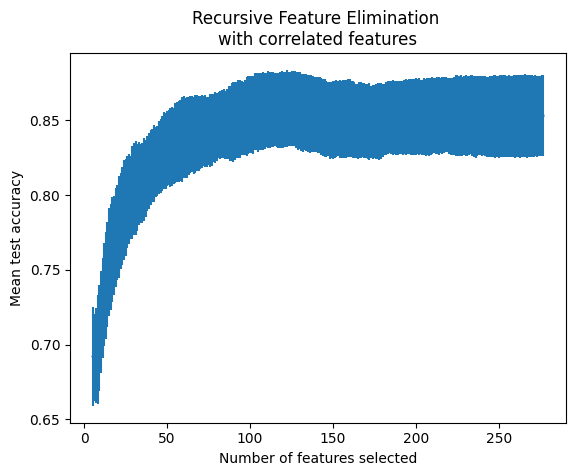

In [31]:
import matplotlib.pyplot as plt

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [32]:
#Model4 （len(columns) descriptors）
Model4_clf=LogisticRegression(C=study.best_params['logreg_c'],max_iter=study.best_params['max_iter'],solver='liblinear',random_state=0)
#Model4
Model4=Model_results(Model4_clf,X_LR,y,Cv_model)
Model4


,Mean,Se
Accuracy_test,0.870290,0.002329
Accuracy_train,0.898535,0.000346
F1 Score,0.874642,0.002229
Precision,0.867954,0.003058
Recall,0.882519,0.003125
Roc_auc,0.932791,0.001737


In [33]:
Model4_clf=Model4_clf.fit(X_LR, y)
#Saving the final model
joblib.dump(Model4_clf, './LogReg.pkl')
LogReg= joblib.load(filename='./LogReg.pkl')

In [34]:
#Saving the data of model performance
Model_data=pd.concat([Model1,Model2,Model3,Model4],axis=1)
Model_data.to_csv("./LR_model_data.csv",sep=',')
Model_data.columns = [['LogisticRegression']*8,['Model 1','Model 1', 'Model 2','Model 2', 'Model 3', 'Model 3', 'Model 4', 'Model 4'], ['Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se']]  
Model_data.columns.names=['Method','Model','Values']
Model_data.to_csv('./LR_model_data.csv',encoding='utf-8')
#Read data：pd.read_csv('./Results/LR_model_data.csv',encoding='utf-8',header=[0,1,2])
Model_data

Method         LogisticRegression                                          \
Model                     Model 1             Model 2             Model 3   
Values                       Mean        Se      Mean        Se      Mean   
Accuracy_test            0.729074  0.003069  0.835016  0.002292  0.852160   
Accuracy_train           0.740275  0.001716  0.866684  0.000319  0.911563   
F1 Score                 0.728109  0.003241  0.839378  0.002296  0.856907   
Precision                0.750605  0.003672  0.838525  0.002950  0.851159   
Recall                   0.708691  0.004521  0.841572  0.003602  0.863928   
Roc_auc                  0.783609  0.003179  0.901966  0.001950  0.915456   

Method                                        
Model                      Model 4            
Values                Se      Mean        Se  
Accuracy_test   0.002243  0.870290  0.002329  
Accuracy_train  0.000339  0.898535  0.000346  
F1 Score        0.002209  0.874642  0.002229  
Precision       0.002912  0.867954  0.003058  
Recall          0.003382  0.882519  0.003125  
Roc_auc         0.002004  0.932791  0.001737

# RF

In [10]:
#Data pre-processing of models
X_test_NAomit=np.array(X_NAomit_data)
X_test_ML=np.array(ML_data)
y=Raw_data['Activite'].values
clf=RandomForestClassifier(random_state=0)

In [11]:
#Model1 （4175 descriptors）
Model1_clf=clf
#Model1
Model1=Model_results(Model1_clf,X_test_NAomit,y,Cv_model)
Model1

,Mean,Se
Accuracy_test,0.870866,0.002054
Accuracy_train,0.992872,0.000085
F1 Score,0.873677,0.002067
Precision,0.876657,0.002663
Recall,0.871741,0.003183
Roc_auc,0.937475,0.001431


In [12]:
#Model2 （40 descriptors）
Model2_clf=clf
Model2_clf.fit(X_test_ML, y)
#Model2
Model2=Model_results(Model2_clf,X_test_ML,y,Cv_model)
Model2

,Mean,Se
Accuracy_test,0.873576,0.002044
Accuracy_train,0.992884,0.000085
F1 Score,0.875917,0.002087
Precision,0.881507,0.002521
Recall,0.871440,0.003345
Roc_auc,0.941924,0.001359


In [13]:
#Tuning hyperparameters
#Step 1. Define an objective function to be maximized.
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators",100,1000,1) #整数型，(参数名称，下界，上界，步长)
    max_depth = trial.suggest_int("max_depth",5,20,1)
    max_features = trial.suggest_int("max_features",5,30,1)
    #max_features = trial.suggest_categorical("max_features",["log2","sqrt","auto"]) #字符型
    min_impurity_decrease = trial.suggest_float("min_impurity_decrease",0,5,log=False) #浮点型
    model = RandomForestClassifier(n_estimators = n_estimators
              ,max_depth = max_depth
              ,max_features = max_features
              ,min_impurity_decrease = min_impurity_decrease
              ,random_state=0
              ,verbose=False
              ,n_jobs=8)

# Step 2: Scoring method:
    score = model_selection.cross_val_score(model, X_test_ML, y, n_jobs=8, scoring="accuracy",cv=Cv_optuna)
    accuracy = score.mean()
    return accuracy
 
# Step 3: Running it
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective, n_trials=100, show_progress_bar=False)

[I 2023-11-12 05:36:41,290] A new study created in memory with name: no-name-a1c9b2d9-894a-4a0f-8fb4-7d6a423c2586
[I 2023-11-12 05:37:47,472] Trial 0 finished with value: 0.5127672338568935 and parameters: {'n_estimators': 594, 'max_depth': 16, 'max_features': 20, 'min_impurity_decrease': 2.724415914984484}. Best is trial 0 with value: 0.5127672338568935.
[I 2023-11-12 05:38:35,411] Trial 1 finished with value: 0.5127672338568935 and parameters: {'n_estimators': 481, 'max_depth': 15, 'max_features': 16, 'min_impurity_decrease': 4.4588650039103985}. Best is trial 0 with value: 0.5127672338568935.
[I 2023-11-12 05:40:32,591] Trial 2 finished with value: 0.5127672338568935 and parameters: {'n_estimators': 968, 'max_depth': 11, 'max_features': 25, 'min_impurity_decrease': 2.644474598764522}. Best is trial 0 with value: 0.5127672338568935.
[I 2023-11-12 05:41:16,790] Trial 3 finished with value: 0.5127672338568935 and parameters: {'n_estimators': 611, 'max_depth': 19, 'max_features': 6, 'mi

In [14]:
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")
# Setting the best model
clf=RandomForestClassifier(n_estimators = study.best_params['n_estimators']
              ,max_depth = study.best_params['max_depth']
              ,max_features = study.best_params['max_features']
              ,min_impurity_decrease = study.best_params['min_impurity_decrease']
              ,random_state=0
              ,verbose=False
              ,n_jobs=8)

The best parameters are : 
{'n_estimators': 485, 'max_depth': 17, 'max_features': 7, 'min_impurity_decrease': 0.0016421163477614784}


In [15]:
#Model3
Model3=Model_results(clf,X_test_ML,y,Cv_model)
Model3

,Mean,Se
Accuracy_test,0.875816,0.001943
Accuracy_train,0.940895,0.000219
F1 Score,0.878310,0.001941
Precision,0.883011,0.002691
Recall,0.874790,0.003187
Roc_auc,0.937034,0.001482


In [16]:
#Recursive feature elimination
min_features_to_select =5
rfecv = RFECV(estimator=clf,step=1,cv=Cv_RFECV,scoring="accuracy",min_features_to_select=min_features_to_select,n_jobs=8)
rfecv.fit(X_test_ML,y)
columns=Series(ML_data.columns.tolist())[rfecv.support_.tolist()].tolist()

In [17]:
data_rf=ML_data[columns]
data_rf.to_csv("./data_rf.csv",sep=',')
X_RF=np.array(data_rf)

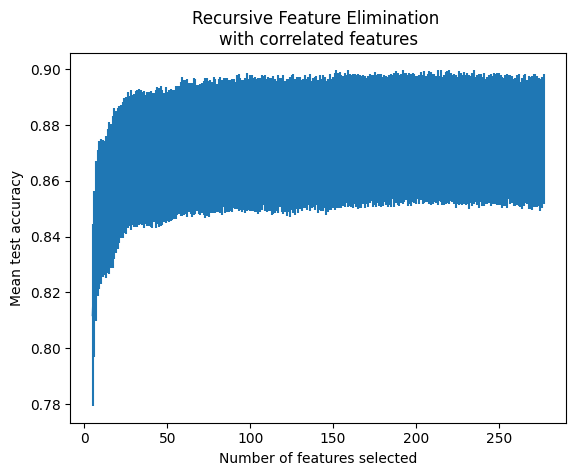

In [18]:
import matplotlib.pyplot as plt
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [19]:
#Model4 （len(columns) descriptors）
Model4_clf=clf=RandomForestClassifier(n_estimators = study.best_params['n_estimators']
              ,max_depth = study.best_params['max_depth']
              ,max_features = study.best_params['max_features']
              ,min_impurity_decrease = study.best_params['min_impurity_decrease']
              ,random_state=0
              ,verbose=False
              ,n_jobs=8)
Model4_clf.fit(X_RF, y)
#Model4
Model4=Model_results(Model4_clf,X_RF,y,Cv_model)
Model4


,Mean,Se
Accuracy_test,0.876179,0.001819
Accuracy_train,0.945435,0.000232
F1 Score,0.878713,0.001808
Precision,0.883122,0.002603
Recall,0.875392,0.002994
Roc_auc,0.937440,0.001466


In [20]:
Model4_clf=Model4_clf.fit(X_RF, y)
#Saving the final model
joblib.dump(Model4_clf, './RF.pkl')
RF= joblib.load(filename='./RF.pkl')

In [21]:
#Saving the data of model performance
Model_data=pd.concat([Model1,Model2,Model3,Model4],axis=1)
Model_data.to_csv("./RF_model_data.csv",sep=',')
Model_data.columns = [['RandomForest']*8,['Model 1','Model 1', 'Model 2','Model 2', 'Model 3', 'Model 3', 'Model 4', 'Model 4'], ['Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se']]  
Model_data.columns.names=['Method','Model','Values']
Model_data.to_csv('./RF_model_data.csv',encoding='utf-8')
#Read data：pd.read_csv('./Results/RF_model_data.csv',encoding='utf-8',header=[0,1,2])
Model_data

Method         RandomForest                                                    \
Model               Model 1             Model 2             Model 3             
Values                 Mean        Se      Mean        Se      Mean        Se   
Accuracy_test      0.870866  0.002054  0.873576  0.002044  0.875816  0.001943   
Accuracy_train     0.992872  0.000085  0.992884  0.000085  0.940895  0.000219   
F1 Score           0.873677  0.002067  0.875917  0.002087  0.878310  0.001941   
Precision          0.876657  0.002663  0.881507  0.002521  0.883011  0.002691   
Recall             0.871741  0.003183  0.871440  0.003345  0.874790  0.003187   
Roc_auc            0.937475  0.001431  0.941924  0.001359  0.937034  0.001482   

Method                              
Model            Model 4            
Values              Mean        Se  
Accuracy_test   0.876179  0.001819  
Accuracy_train  0.945435  0.000232  
F1 Score        0.878713  0.001808  
Precision       0.883122  0.002603  
Recall          0.875392  0.002994  
Roc_auc         0.937440  0.001466

# xgboost

In [29]:
#Data pre-processing of models
X_test_NAomit=np.array(X_NAomit_data)
X_test_ML=np.array(ML_data)
y=Raw_data['Activite'].values
clf=xgb.XGBClassifier(random_state=0)

In [19]:
#Model1 （4175 descriptors）
Model1_clf=clf
#Model1
Model1=Model_results(Model1_clf,X_test_NAomit,y,Cv_model)
Model1

KeyboardInterrupt: 

In [20]:
#Model2 （40 descriptors）
Model2_clf=clf
Model2_clf.fit(X_test_ML, y)
#Model2
Model2=Model_results(Model2_clf,X_test_ML,y,Cv_model)
Model2

,Mean,Se
Accuracy_test,0.871490,0.002089
Accuracy_train,0.992936,0.000084
F1 Score,0.874571,0.002059
Precision,0.875795,0.002690
Recall,0.874274,0.003046
Roc_auc,0.941065,0.001345


In [24]:
#Model2 （40 descriptors）
Model2_clf=clf
Model2_clf.fit(X_test_ML, y)
#Model2
Model2=Model_results(Model2_clf,X_test_ML,y,Cv_model)
Model2

,Mean,Se
Accuracy_test,0.870864,0.002107
Accuracy_train,0.992936,0.000084
F1 Score,0.873517,0.002103
Precision,0.877766,0.002796
Recall,0.870402,0.003241
Roc_auc,0.941711,0.001370


In [36]:
#Tuning hyperparameters
#Step 1. Define an objective function to be maximized.
def objective(trial):
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3,1.0,step=0.1),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0, step=0.1),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.2, step=0.005),
        'n_estimators': trial.suggest_int("n_estimators",50,1000,1)
        #'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBClassifier(**param,random_state=1,n_jobs=8)

 
# Step 2: Scoring method:
    score = model_selection.cross_val_score(model, X_test_ML, y, n_jobs=8, scoring="accuracy",cv=Cv_optuna)
    accuracy = score.mean()
    return accuracy

# Step 3: Running it
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective, n_trials=100, show_progress_bar=False)


[I 2024-10-30 07:10:49,474] A new study created in memory with name: no-name-2882d476-b2f3-4c16-a22e-a552535955d4
[W 2024-10-30 07:11:18,279] Trial 0 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "E:\C++\anaconda\envs\hydrogel\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\A\AppData\Local\Temp\ipykernel_16492\1659740175.py", line 17, in objective
    score = model_selection.cross_val_score(model, X_test_ML, y, n_jobs=8, scoring="accuracy",cv=Cv_optuna)
  File "E:\C++\anaconda\envs\hydrogel\lib\site-packages\sklearn\model_selection\_validation.py", line 515, in cross_val_score
    cv_results = cross_validate(
  File "E:\C++\anaconda\envs\hydrogel\lib\site-packages\sklearn\model_selection\_validation.py", line 266, in cross_validate
    results = parallel(
  File "E:\C++\anaconda\envs\hydrogel\lib\site-packages\joblib\parallel.py", line 1056, in __call__
    se

KeyboardInterrupt: 

In [26]:
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")
# Setting the best model
clf=xgb.XGBClassifier(alpha = study.best_params['alpha']
              ,colsample_bytree = study.best_params['colsample_bytree']
              ,subsample = study.best_params['subsample']
              ,n_estimators = study.best_params['n_estimators']
              ,learning_rate= study.best_params['learning_rate'], n_jobs=8
              ,random_state=0)

The best parameters are : 
{'lambda': 0.012041246302698939, 'alpha': 1.8968094659953247, 'colsample_bytree': 0.9000000000000001, 'subsample': 0.9, 'learning_rate': 0.1551, 'n_estimators': 230}


In [27]:
#Model3
Model3=Model_results(clf,X_test_ML,y,Cv_model)
Model3

,Mean,Se
Accuracy_test,0.870812,0.001842
Accuracy_train,0.992936,0.000084
F1 Score,0.873845,0.001829
Precision,0.875480,0.002558
Recall,0.873265,0.003032
Roc_auc,0.943855,0.001255


In [39]:
#Recursive feature elimination
min_features_to_select =5
rfecv = RFECV(estimator=clf,step=1,cv=Cv_RFECV,scoring="accuracy",min_features_to_select=min_features_to_select,n_jobs=8)
rfecv.fit(X_test_ML,y)
columns=Series(ML_data.columns.tolist())[rfecv.support_.tolist()].tolist()

KeyboardInterrupt: 

In [ ]:
data_xgb=ML_data[columns]
data_xgb.to_csv("./data_xgb.csv",sep=',')
X_XGB=np.array(data_xgb)

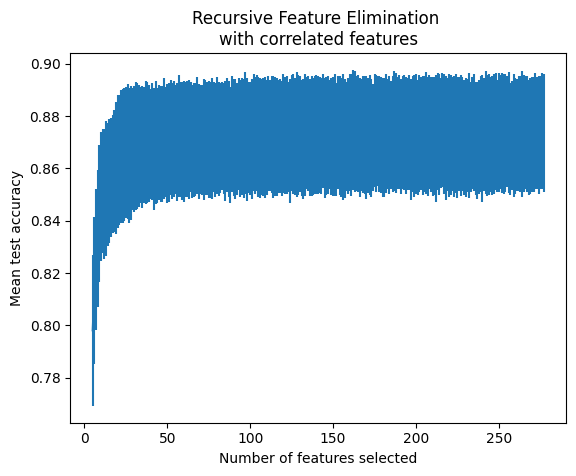

In [30]:
import matplotlib.pyplot as plt
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [30]:
#Model4 （len(columns) descriptors）
Model4_clf=xgb.XGBClassifier(alpha = study.best_params['alpha']
              ,colsample_bytree = study.best_params['colsample_bytree']
              ,subsample = study.best_params['subsample']
              ,n_estimators = study.best_params['n_estimators']
              ,learning_rate= study.best_params['learning_rate'], n_jobs=8
              ,random_state=0)
Model4_clf.fit(X_XGB, y)
#Model4
Model4=Model_results(Model4_clf,X_XGB,y,Cv_model)
Model4


NameError: name 'study' is not defined

In [40]:
data_xgb=pd.read_csv("./data_xgb.csv",sep=',',header=0,index_col=0)

In [41]:
X_XGB=np.array(data_xgb)

In [42]:
#Model4 （len(columns) descriptors）
Model4_clf=xgb.XGBClassifier(alpha =1.8968094659953247
              ,colsample_bytree = 0.9000000000000001
              ,subsample = 0.9
              ,n_estimators = 230
              ,learning_rate= 0.1551, n_jobs=8
              ,random_state=0)
Model4_clf.fit(X_XGB, y)
#Model4
Model4=Model_results(Model4_clf,X_XGB,y,Cv_model)
Model4

,Mean,Se
Accuracy_test,0.872323,0.001956
Accuracy_train,0.992936,0.000084
F1 Score,0.875322,0.001930
Precision,0.877053,0.002646
Recall,0.874579,0.002988
Roc_auc,0.944919,0.001305


In [ ]:
'lambda': 0.012041246302698939, 'alpha': 1.8968094659953247, 'colsample_bytree': 0.9000000000000001, 'subsample': 0.9, 'learning_rate': 0.1551, 'n_estimators': 230

In [43]:
Model4_clf=Model4_clf.fit(X_XGB, y)
#Saving the final model
joblib.dump(Model4_clf, './XGB.pkl')
XGB= joblib.load(filename='./XGB.pkl')

In [33]:
#Saving the data of model performance
Model_data=pd.concat([Model1,Model2,Model3,Model4],axis=1)
Model_data.to_csv("./XGB_model_data.csv",sep=',')
Model_data.columns = [['XGBoost']*8,['Model 1','Model 1', 'Model 2','Model 2', 'Model 3', 'Model 3', 'Model 4', 'Model 4'], ['Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se']]  
Model_data.columns.names=['Method','Model','Values']
Model_data.to_csv('./XGB_model_data.csv',encoding='utf-8')
#Read data：pd.read_csv('./Results/LR_model_data.csv',encoding='utf-8',header=[0,1,2])
Model_data

Method           XGBoost                                                    \
Model            Model 1             Model 2             Model 3             
Values              Mean        Se      Mean        Se      Mean        Se   
Accuracy_test   0.868883  0.002034  0.870864  0.002107  0.870812  0.001842   
Accuracy_train  0.992936  0.000084  0.992936  0.000084  0.992936  0.000084   
F1 Score        0.871964  0.002018  0.873517  0.002103  0.873845  0.001829   
Precision       0.873711  0.002761  0.877766  0.002796  0.875480  0.002558   
Recall          0.871322  0.003136  0.870402  0.003241  0.873265  0.003032   
Roc_auc         0.942397  0.001362  0.941711  0.001370  0.943855  0.001255   

Method                              
Model            Model 4            
Values              Mean        Se  
Accuracy_test   0.872791  0.002019  
Accuracy_train  0.992936  0.000084  
F1 Score        0.875896  0.001991  
Precision       0.876892  0.002742  
Recall          0.875898  0.002993  
Roc_auc         0.945048  0.001297

In [31]:
XGB= joblib.load(filename='./XGB.pkl')
data_xgb=pd.read_csv("./data_xgb.csv",sep=',',header=0,index_col=0)

[07:08:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



In [33]:
X_test_dataframe=pd.read_csv("./X_test_data.csv",sep=',',index_col=0)
X_test_last=X_test_dataframe[data_xgb.columns.to_list()]
X_test=np.array(X_test_last)
X_test_last.head()


,IC2,F05[N-O],Vindex,SHED_AL,SM6_B(v),F08[C-N],F03[N-O],P_VSA_LogP_4,CATS2D_03_DA,MaxdO,...,N%,s2_phSize,SpMAD_AEA(ri),MCD,Mi,MaxdssC,GATS5m,GATS5e,MATS7i,GATS8v
cid,,,,,,,,,,,,,,,,,,,,,
5273,0.616671,0.000000,0.003547,0.290379,0.236715,0.000000,0.000000,0.041688,0.048780,0.0,...,0.740741,0.000000,0.649293,0.933333,0.621460,0.486062,0.628923,0.483891,0.126944,0.380561
13463,0.679473,0.032787,0.003225,0.258153,0.275319,0.010417,0.024390,0.050490,0.121951,0.0,...,0.645161,0.187500,0.685494,0.736842,0.614779,0.486062,0.579623,0.441163,0.279268,0.501195
39148,0.703414,0.049180,0.003133,0.000000,0.286492,0.010417,0.073171,0.050490,0.121951,0.0,...,0.615385,0.312500,0.697651,0.666667,0.634297,0.486062,0.632788,0.626557,0.155006,0.452583
56328,0.723848,0.016393,0.003233,0.207138,0.262769,0.010417,0.000000,0.050490,0.048780,0.0,...,0.666667,0.083333,0.667541,0.777778,0.666716,0.486062,0.582434,0.499556,0.398473,0.519243
67358,0.688030,0.049180,0.003258,0.000000,0.285322,0.010417,0.048780,0.043736,0.146341,0.0,...,0.606061,0.312500,0.702330,0.700000,0.638476,0.486062,0.552950,0.480100,0.282165,0.525810


In [45]:
#Predicted results
Predicted_data=pd.DataFrame(XGB.predict_proba(X_test),columns=['Probability of nonactivity','Probability of activity'])
Predicted_data.index=X_test_last.index
Predicted_data.sort_values(by="Probability of activity" , inplace=True, ascending=False)
Predicted_data.to_csv("./XGB_predict_data.csv",sep=',')